(latent-change-notebook)=
# Modello LCS univariato

I *Latent Change Score Models* (LCSM; McArdle, 2001, 2009; McArdle & Hamagami, 2001) costituiscono un ulteriore sviluppo dei modelli dedicati all'analisi dei dati longitudinali. Per chiarire la differenza tra i modelli LGM e i modelli LCSM, è importante considerare come entrambi modellino il cambiamento nel tempo.

- I modelli LGM sono utilizzati per descrivere le traiettorie di crescita di una variabile nel tempo. In un LGM, la variabile latente (che rappresenta il cambiamento) è modellata direttamente attraverso diverse misurazioni nel tempo. Questi modelli cercano di catturare il pattern di crescita o declino di una variabile (ad esempio, l'abilità cognitiva o un sintomo clinico) attraverso diversi momenti. Un LGM si concentra sull'intero percorso della variabile e sull'interpretazione di come questa traiettoria cambia in risposta a vari fattori.
- I modelli LCSM, d'altra parte, mettono l'accento sul *cambiamento* specifico che avviene tra due momenti consecutivi nel tempo. Questi modelli sono particolarmente utili quando l'interesse è focalizzato su come e perché una variabile cambia da un momento all'altro. Invece di guardare la traiettoria generale come nei LGM, i modelli LCSM esaminano il cambiamento incrementale, consentendo una maggiore comprensione delle dinamiche del cambiamento. I modelli LCSM si concentrano su come i cambiamenti in una variabile (ad esempio, l'abilità cognitiva) da un momento all'altro sono associati a fattori esterni o ad altre variabili misurate.

Mentre i modelli LGM sono usati per studiare la progressione generale di un fenomeno nel tempo, i modelli LCSM sono invece utilizzati per indagare come e perché avviene il cambiamento in risposta a vari fattori. Inoltre, i modelli LCSM forniscono un'analisi più granulare del cambiamento, separando il cambiamento intra-individuale dalla variabilità inter-individuale e consentendo un'esplorazione più dettagliata delle dinamiche del cambiamento.

In questo capitolo inizieremo ad esaminare i modelli LCSM univariati; poi considereremo il caso bivariato.

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
    library("lcsm")
    library("tidyr")
    library("stringr")
    library("reshape2")
})

ERROR: Error in library("lcsm"): non c'è alcun pacchetto chiamato ‘lcsm’


## Analisi di una Misura Unica in Due Momenti Temporali

Iniziamo con il caso più semplice di una singola variabile misurata in due diversi momenti nel tempo. Immaginiamo, ad esempio, un ricercatore che studia un qualche aspetto psicologico, misurando una determinata variabile su un gruppo di soggetti in due periodi distinti, identificati come Tempo 1 (T1) e Tempo 2 (T2). L'approccio convenzionale per analizzare se i punteggi di un gruppo di individui variano tra T1 e T2 è quello di utilizzare il test t di Student per dati appaiati. Questo test, ampiamente utilizzato per confrontare le medie di due misurazioni correlate (come i punteggi di uno stesso gruppo di individui in due momenti diversi), permette di stabilire se ci sia stata una variazione "statisticamente significativa" nei punteggi medi del gruppo di soggetti tra i due momenti considerati. Il modello *Latent Change Score* (LCS) offre una prospettiva più avanzata e dettagliata rispetto al test t di Student tradizionale. Il modello LCS permette non solo di valutare se ci sia stata una variazione nei punteggi medi, ma anche di esaminare la natura di questa variazione su base individuale. Mentre il test t tradizionale si concentra sul cambiamento a livello di gruppo, il modello LCS ci consente di indagare come e perché ogni singolo individuo nel campione possa aver sperimentato un cambiamento tra T1 e T2.

Utilizziamo lo script fornito da {cite:t}`kievit2018developmental` per simulare i dati che corrispondono alla situazione descritta sopra.

In [3]:
ULCS_simulate <- '
    ##### The following lines specify the core assumptions of the LCS 
    ##### and should not generally be modified

    COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2     # Fixed regression of dCOG1 on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0  


    ###### The following five parameters will be estimated in the model. 
    ###### Values can be modified manually to examine the effect on the model

    dCOG1 ~ 4*1         # This fixes the intercept of the change score to 10 
    COG_T1 ~ 10*1       # This fixes the intercept of COG_T1 to 50 

    dCOG1 ~~ 5*dCOG1    # This fixes the variance of the change scores to 5. 
    COG_T1 ~~ 8*COG_T1  # This fixes the variance of the COG_T1 to 8. 

    dCOG1 ~ -0.1*COG_T1 # This fixes the self-feedback parameter to -0.1. 
'

In [4]:
set.seed(42)
samplesize <- 100
simdatULCS <- simulateData(ULCS_simulate, sample.nobs = samplesize, meanstructure = TRUE) 
head(simdatULCS)

,COG_T2,COG_T1
,<dbl>,<dbl>
1,9.673594,5.047393
2,15.824384,10.192440
3,10.870739,10.273960
4,12.686939,6.160675
5,11.054693,9.764821
6,13.444989,10.145172


In [5]:
print(colMeans(simdatULCS)) # sanity check the means

  COG_T2   COG_T1 
12.81156 10.02172 


Interpretiamo i valori precedenti come le medie calcolate sulla base dei risultati di 100 soggetti dei punteggi di un ipotetico test cognitivo nei momenti T1 e T2.

Da un punto di vista matematico, modelliamo i punteggi di un individuo $i$ sul costrutto di interesse COG al tempo $t$ come risultato di una componente autoregressiva più un residuo. Stabilendo un peso di regressione di 1 per COG_T2 rispetto a COG_T1, l'equazione autoregressiva diventa:

$$
COG_{i,t2} = COG_{i,t1} + \Delta COG_{i,1}.
$$

```{figure} ../images/kevit_1.png
---
height: 400px
name: kevit1-fig
---
**Diagramma di percorso semplificato di un LCSM univariato.** La variabile COG viene misurata in due momenti (COG_T1 e COG_T2). Il cambiamento (ΔCOG1) tra i due momenti viene modellato come una variabile latente. (La figura è tratta da {cite:t}`kievit2018developmental`.)
```


Questa formulazione indica che il punteggio di COG al tempo 2 (COG_{i,t2}) è uguale al punteggio al tempo 1 (COG_{i,t1}) più un cambiamento latente ($\Delta COG_{i,1}$).

Il cambiamento latente può essere definito come:

$$
\Delta COG_{i,1} = COG_{i,t2} - COG_{i,t1}.
$$

In questo contesto, all'interno dei modelli SEM, si introduce un fattore latente $\Delta COG1$, che rappresenta il cambiamento tra il tempo 1 e il tempo 2. Questo fattore latente è identificato al tempo 2 con un carico fattoriale fissato a 1, catturando così il cambiamento osservato.

È poi possibile aggiungere un parametro di regressione $\beta$ al modello, per indagare se il grado di cambiamento dipenda dai punteggi al tempo 1:

$$
\Delta COG_{i,1} = \beta \cdot COG_{i,t1}.
$$

Con questo modello, possiamo rispondere a tre questioni fondamentali. La prima riguarda l'esistenza di un cambiamento medio significativo da T1 a T2, misurato dalla media del fattore di cambiamento latente, $\mu_{\Delta COG1}$. Questo approccio può essere considerato equivalente a un test t di Student per dati appaiati sotto determinate condizioni. Oltre a questo, il modello permette di stimare la varianza del fattore di cambiamento, $\sigma^2_{\Delta COG1}$, che riflette quanto gli individui differiscono nel cambiamento nel tempo. Infine, si può specificare un parametro autoregressivo o una covarianza $\beta$, che quantifica la dipendenza del cambiamento dai punteggi iniziali.

In sintesi, il modello LCS fornisce un quadro robusto per analizzare i cambiamenti nel tempo in un costrutto latente, offrendo sia una stima del cambiamento medio sia una misura della varianza individuale in questo cambiamento, e valutando l'effetto dei punteggi iniziali sul cambiamento stesso.

Il precedente modello LCS può essere formulato nella sintassi di `lavaan` nel modo seguente.

In [6]:
ULCS <- '
    COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2     # Fixed loading of dCOG1 on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0 

    dCOG1 ~ 1             # This estimates the intercept of the change scores 
    COG_T1 ~ 1            # This estimates the intercept of COG_T1 
    dCOG1 ~~ dCOG1        # This estimates the variance of the change scores 
    COG_T1 ~~ COG_T1      # This estimates the variance of COG_T1 
    dCOG1 ~ COG_T1        # This estimates the self-feedback parameter
'

Adattiamo ai dati simulati il modello LCS specificato sopra.

In [7]:
fitULCS <- lavaan(ULCS, data=simdatULCS, estimator='mlr', fixed.x=FALSE, missing='fiml')

Esaminiamo la soluzione.

In [47]:
summary(fitULCS, fit.measures = TRUE, standardized = TRUE, rsquare = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 37 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         5

  Number of observations                           100
  Number of missing patterns                         1

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                 0.000       0.000
  Degrees of freedom                                 0           0

Model Test Baseline Model:

  Test statistic                               105.669      85.223
  Degrees of freedom                                 1           1
  P-value                                        0.000       0.000
  Scaling correction factor                                  1.240

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000       1.000
  Tucker-Lewis Index (TLI)                       

Il cambiamento nel punteggio latente tra i momenti T1 e T2 è stimato essere uguale a 3.166 (SE = 0.648). Questo valore può essere messo in relazione alla differenza tra le medie dei punteggi in due momenti temporali che viene calcolata da un test t di Student per dati appaiati. Si noti però che, mentre nel caso del test t la differenza riguarda i punteggi osservati, nei modelli LSC essa descrive la variazione tra i punteggi latenti nei momenti T1 e T2.

In [53]:
t.test(x = simdatULCS$COG_T1, y = simdatULCS$COG_T2)


	Welch Two Sample t-test

data:  simdatULCS$COG_T1 and simdatULCS$COG_T2
t = -6.1614, df = 192.21, p-value = 4.142e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.682920 -1.896764
sample estimates:
mean of x mean of y 
 10.02172  12.81156 


Il coefficiente 4.140 (SE = 0.733) stima la varianza con la quale gli individui differiscono nel cambiamento che manifestano nel tempo. Infine, il coefficiente -0.038 (SE = 0.064) stima la componente autoregressiva dal tempo T1 al tempo T2.

Mediante `semPaths` possiamo generare il seguente diagramma di percorso.

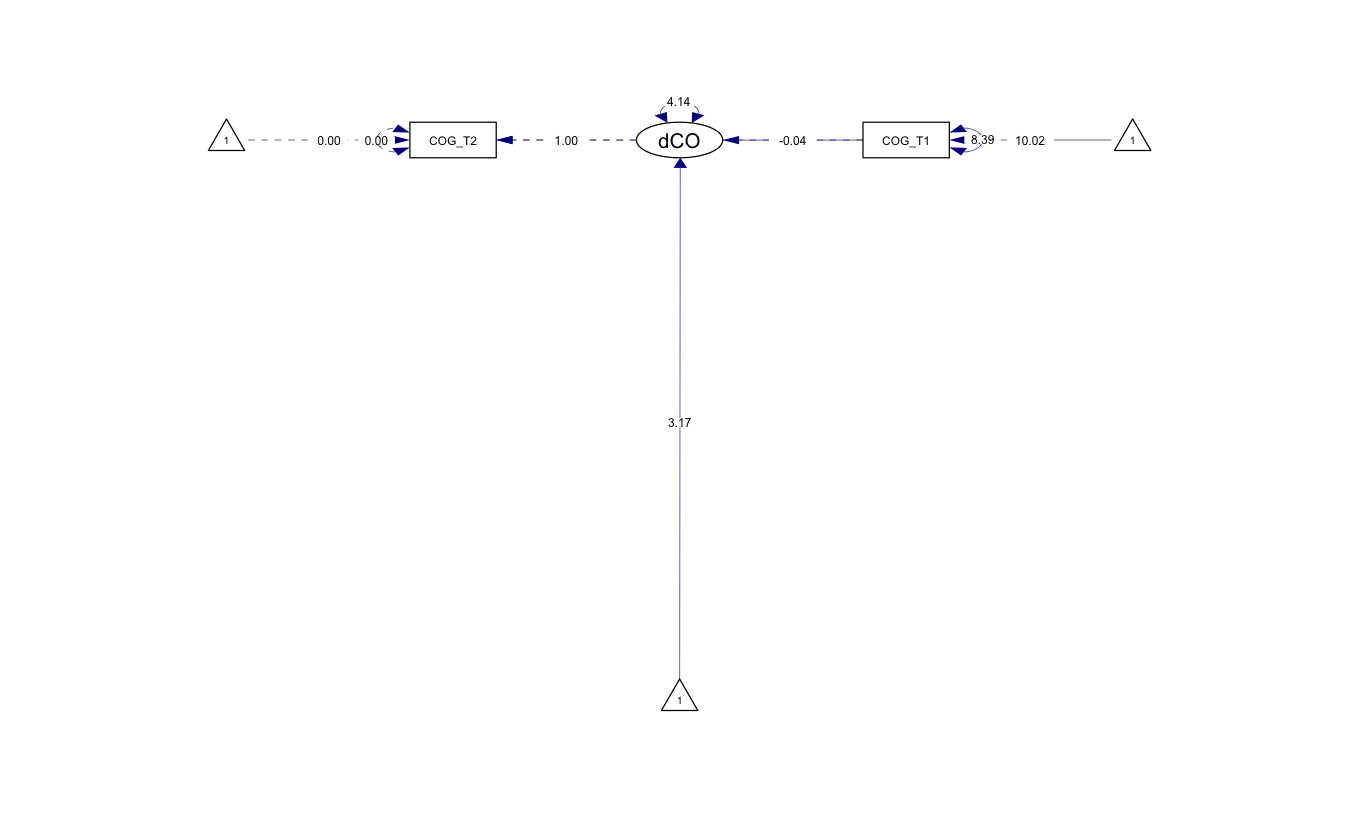

In [8]:
fitULCS |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE,
        node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

## Indicatori multipli in due rilevazioni temporali

Quello esaminato sopra era il caso più semplice di un modello LCS. Più comune è il caso in cui vengono esaminati indicatori multipli in due diversi momenti del tempo. Anche in questo caso, iniziamo simulando i dati per la situazione descritta mediante lo script fornito da {cite:t}`kievit2018developmental`.

In [9]:
#Simulate data for a Univariate Latent Change Score model. 
MILCS_simulate <- '
    ####    The following two lines specify the measurement model for multiple indicators (X1-X3) 
    ####    measured on two occasions (T1-T2)
    COG_T1=~.8*T1X1+.9*T1X2+.7*T1X3   # This specifies the measurement model for COG_T1 
    COG_T2=~.8*T2X1+.9*T2X2+.7*T2X3   # This specifies the measurement model for COG_T2 

    #####     The following lines specify the core assumptions of the LCS 
    #####     and should not generally be modified

    COG_T2 ~ 1*COG_T1           # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2           # Fixed regression of dCOG1 on COG_T2
    COG_T2 ~ 0*1                # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2          # This fixes the variance of the COG_T2 to 0  

    T1X1~0*1                  # This fixes the intercept of X1 to 0
    T1X2~1*1                  # This fixes the intercept of X2 to 1
    T1X3~.5*1                 # This fixes the intercept of X3 to 0.5 
    T2X1~0*1                  # This fixes the intercept of X1 to 0
    T2X2~1*1                  # This fixes the intercept of X2 to 1
    T2X3~.5*1                 # This fixes the intercept of X3 to 0.5

    ###### The following five parameters will be estimated in the model. 
    ###### Values can be modified manually to examine the effect on the model

    dCOG1 ~ 10*1            # This fixes the intercept of the change score to 10 
    COG_T1 ~ 50*1           # This fixes the intercept of COG_T1 to 50. 
    dCOG1 ~~ 5*dCOG1        # This fixes the variance of the change scores to 5. 
    COG_T1 ~~ 8*COG_T1      # This fixes the variance of the COG_T1 to 8. 
    dCOG1 ~ -0.1*COG_T1       # This fixes the self-feedback parameter to -0.1. 
'

Simuliamo i dati.

In [10]:
set.seed(123)
samplesize <- 100
simdatMILCS <- simulateData(MILCS_simulate, sample.nobs = samplesize, meanstructure = TRUE) 

Queste sono le medie delle tre variabili nei due momenti temporali.

In [11]:
print(colMeans(simdatMILCS))

    T1X1     T1X2     T1X3     T2X1     T2X2     T2X3 
39.89147 45.96496 35.41306 43.77188 50.13512 38.59128 


Esaminiamo come variano i punteggi dei tre indicatori nei due momenti del tempo.

Using id, Indicator as id variables



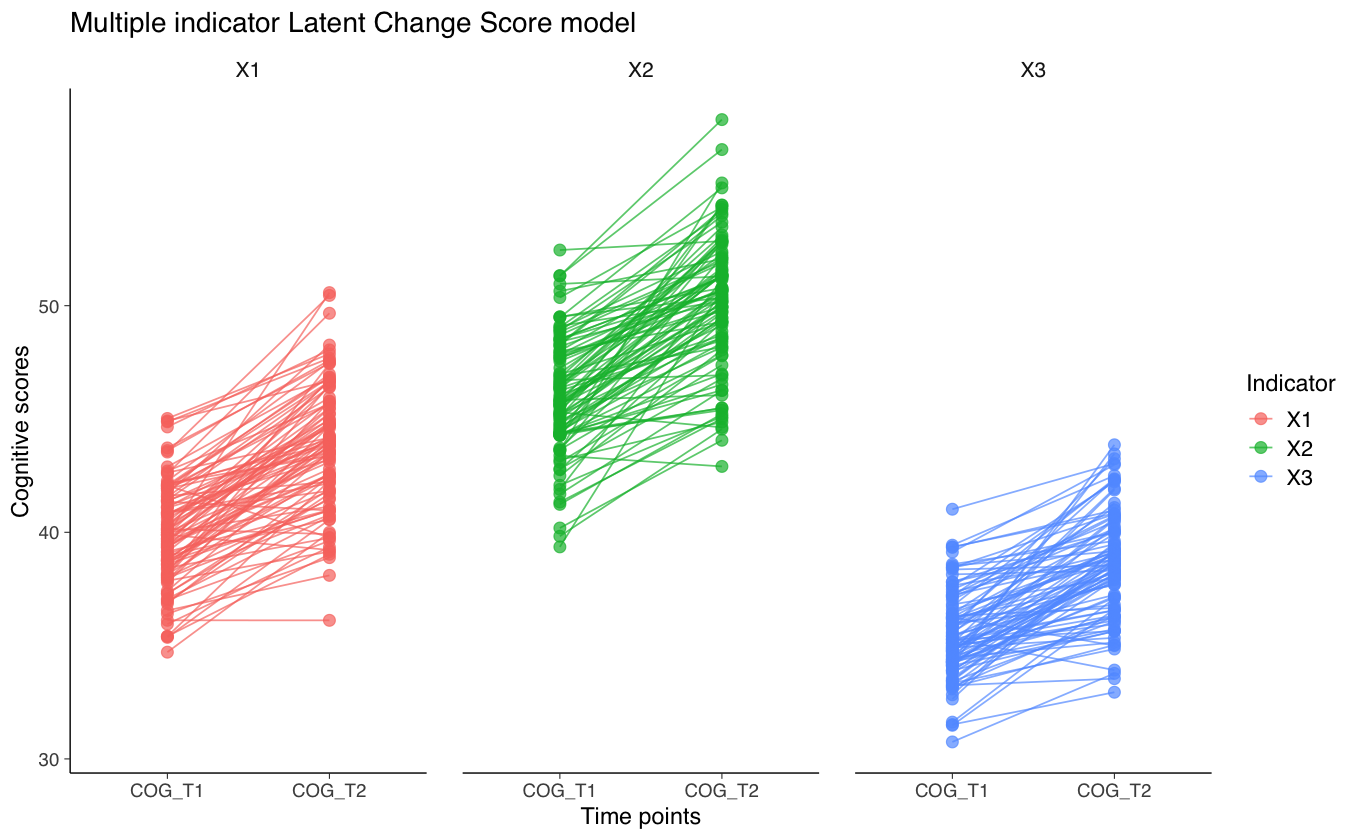

In [13]:
id <- factor(1:samplesize)
plotdattemp <- data.frame(
    c(simdatMILCS$T1X1, simdatMILCS$T1X2, simdatMILCS$T1X3),
    c(simdatMILCS$T2X1, simdatMILCS$T2X2, simdatMILCS$T2X3),
    as.factor(c(id, id, id)),
    c(
        rep("X1", times = samplesize),
        rep("X2", times = samplesize),
        rep("X3", times = samplesize)
    )
)
colnames(plotdattemp) <- c("COG_T1", "COG_T2", "id", "Indicator")
plotdat <- melt(plotdattemp, by = "id")
ggplot(plotdat, aes(variable, value, group = id, col = Indicator)) +
    geom_point(size = 3, alpha = .7) +
    geom_line(alpha = .7) +
    ggtitle("Multiple indicator Latent Change Score model") +
    ylab("Cognitive scores") +
    xlab("Time points") +
    facet_grid(~Indicator)

Definiamo il modello LCS per indicatori multipli e due momenti temporali mediante il codice fornito da {cite:t}`kievit2018developmental`.

In [16]:
MILCS <- '
    COG_T1 =~ 1*T1X1+T1X2+T1X3  # This specifies the measurement model for COG_T1 
    COG_T2 =~ 1*T2X1+equal("COG_T1=~T1X2")*T2X2+equal("COG_T1=~T1X3")*T2X3   # This specifies the measurement model for COG_T2 with the equality constrained factor loadings

    COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2     # Fixed regression of dCOG1 on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0 

    dCOG1 ~ 1             # This estimates the intercept of the change score 
    COG_T1 ~  1           # This estimates the intercept of COG_T1 
    dCOG1 ~~ dCOG1        # This estimates the variance of the change scores 
    COG_T1 ~~ COG_T1      # This estimates the variance of the COG_T1 
    dCOG1~COG_T1          # This estimates the self-feedback parameter

    T1X1~~T2X1   # This allows residual covariance on indicator X1 across T1 and T2
    T1X2~~T2X2   # This allows residual covariance on indicator X2 across T1 and T2
    T1X3~~T2X3   # This allows residual covariance on indicator X3 across T1 and T2

    T1X1~~T1X1   # This allows residual variance on indicator X1 
    T1X2~~T1X2   # This allows residual variance on indicator X2
    T1X3~~T1X3   # This allows residual variance on indicator X3

    T2X1~~equal("T1X1~~T1X1")*T2X1  # This allows residual variance on indicator X1 at T2 
    T2X2~~equal("T1X2~~T1X2")*T2X2  # This allows residual variance on indicator X2 at T2 
    T2X3~~equal("T1X3~~T1X3")*T2X3  # This allows residual variance on indicator X3 at T2

    T1X1~0*1                 # This constrains the intercept of X1 to 0 at T1
    T1X2~1                   # This estimates the intercept of X2 at T1
    T1X3~1                   # This estimates the intercept of X3 at T1
    T2X1~0*1                 # This constrains the intercept of X1 to 0 at T2
    T2X2~equal("T1X2~1")*1   # This estimates the intercept of X2 at T2
    T2X3~equal("T1X3~1")*1   # This estimates the intercept of X3 at T2
'

Il modello "MILCS" rappresenta un'estensione del caso precedente, che riguardava un singolo indicatore in due momenti temporali. Nel modello MILCS, COG_T1 e COG_T2 sono variabili latenti identificate da più indicatori (T1X1, T1X2, T1X3 per COG_T1 e T2X1, T2X2, T2X3 per COG_T2). Questo offre una comprensione più ricca di ogni misurazione cognitiva, catturando diverse sfaccettature o aspetti in ciascun momento temporale.

Vengono introdotti vari vincoli per l'identificazione del modello.

1. **Vincoli di Regressione e delle Intercette**: Come nel modello precedente, la regressione di COG_T2 su COG_T1 è fissata e l'intercetta di COG_T2 è vincolata a 0, così come la varianza di COG_T2.

2. **Vincoli di Carico Fattoriale Uguale**: Un aspetto nuovo di MILCS è l'uso di vincoli di eguaglianza sulle saturazioni fattoriali degli indicatori corrispondenti di COG_T1 e COG_T2 (ad es., `equal("COG_T1=~T1X2")*T2X2`). Questo assicura che gli indicatori misurino lo stesso costrutto in modo consistente attraverso i due tempi.

3. **Covarianza Residua e Varianza degli Indicatori**: Il modello permette covarianze residue tra gli stessi indicatori attraverso i tempi (es. T1X1~~T2X1) e stima la varianza residua per ogni indicatore in entrambi i momenti temporali.

4. **Stima degli Intercette degli Indicatori**: Vengono fissati vincoli sulle intercette degli indicatori. Il vincolo `T1X1~0*1` fissa l'intercetta dell'indicatore T1X1 a 0. Questo significa che, per l'indicatore T1X1, il punto di partenza o il valore di base è impostato a zero. Questo fornisce un punto di riferimento standardizzato per l'analisi degli indicatori all'interno del modello. Al contrario, le intercette per altri indicatori come T1X2 sono stimate liberamente, permettendo al modello di adattarsi meglio ai dati.

Il modello consente di interpretare il cambiamento non solo in termini di un'unica misurazione globale, ma attraverso varie dimensioni, fornendo insight più dettagliati sulle dinamiche del cambiamento cognitivo. Il diagramma di percorso per il modello MILCS è fornito nella figura seguente.

```{figure} ../images/kievit_2.jpg
---
height: 550px
name: kevit2-fig
---
**Diagramma di percorso di un LCSM univariato con indicatori multipli.** Il costrutto latente di interesse (COG) viene misurato in due momenti temporali (COG_T1 e COG_T2), ciascuno utilizzando tre indicatori (X1, X2, X3). Si assume l'invarianza della misurazione e gli errori residui correlati nel tempo. (La figura è tratta da {cite:t}`kievit2018developmental`.)
```

Adattiamo il modello ai dati.

In [17]:
fitMILCS <- lavaan(MILCS, data=simdatMILCS, estimator='mlr', fixed.x=FALSE, missing='fiml')

Esaminiamo la soluzione.

In [18]:
summary(fitMILCS, fit.measures = TRUE, standardized = TRUE, rsquare = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 62 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        22
  Number of equality constraints                     7

  Number of observations                           100
  Number of missing patterns                         1

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                10.053      10.011
  Degrees of freedom                                12          12
  P-value (Chi-square)                           0.611       0.615
  Scaling correction factor                                  1.004
    Yuan-Bentler correction (Mplus variant)                       

Model Test Baseline Model:

  Test statistic                               610.567     592.305
  Degrees of freedom                                15          15
  P-value                     

- L'intercetta di dCOG1, che è 7.885 con un errore standard di 3.207, rappresenta il valore medio stimato del cambiamento latente (dCOG1) nel campione. Questo numero indica la media generale del cambiamento osservato, considerando tutti gli individui nel campione.

- La varianza di dCOG1, che è 3.230 con un errore standard di 0.675, descrive la varianza nel cambiamento del costrutto tra gli individui nel tempo. Questo valore indica quanto gli individui differiscono nel loro cambiamento, riflettendo l'eterogeneità del cambiamento nel campione.

- Il coefficiente di -0.100 con un errore standard di 0.079 nella regressione di dCOG1 su COG_T1 rappresenta il parametro autoregressivo, che indica l'effetto della misura iniziale (COG_T1) sul cambiamento (dCOG1). Un valore negativo suggerisce che valori più alti di COG_T1 sono associati a una riduzione nel cambiamento (dCOG1), ma poiché il valore p (0.206) non è significativo, non possiamo confermare con sicurezza questa relazione nel modello.

I valori di CFI e TLI molto vicini o uguali a 1, RMSEA e SRMR molto bassi, e un p-value elevato per il test di chi-quadrato indicano un buon adattamento del modello ai dati. Questi risultati suggeriscono che il modello specificato si adatta bene ai dati osservati.

Generiamo il diagramma di percorso usando `semPaths()`.

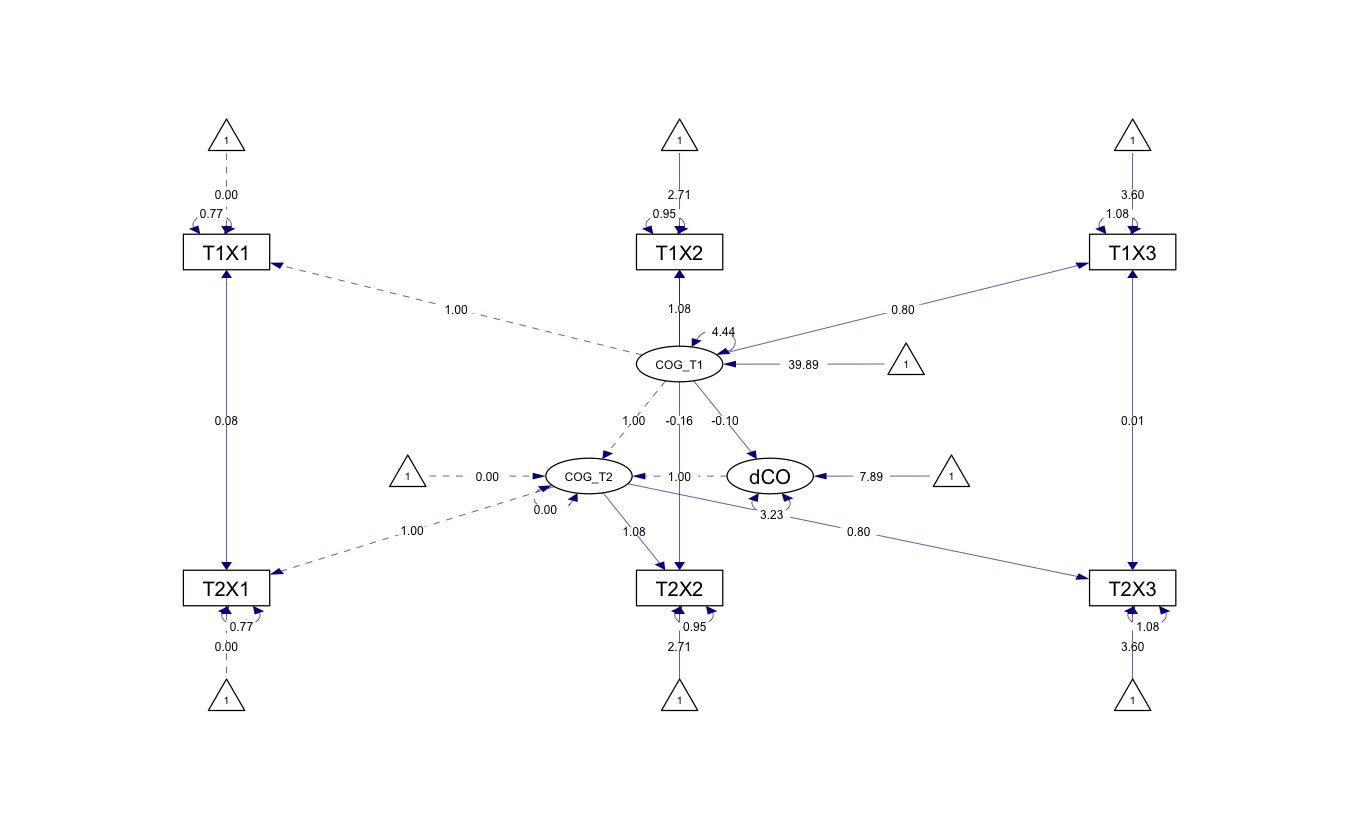

In [19]:
fitMILCS |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 1,
        equalizeManifests = FALSE, optimizeLatRes = TRUE,
        node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

Questo modello è simile al modello univariato LCS per quanto riguarda le domande chiave a cui può rispondere (tasso di cambiamento $\mu_{\Delta COG1}$, varianza nel cambiamento $\sigma^2_{\Delta COG1}$, e la relazione tra COG1 e $\Delta COG1$ catturata da $\beta$), ma include i vantaggi della rimozione degli errori di misurazione e dell'istituzione dell'invarianza della misurazione nel tempo e, se necessario, tra gruppi diversi, migliorando così la qualità delle inferenze.

## Modello LCS Bivariato

I modelli LCS sono stati sviluppati principalmente per studiare le associazioni sequenziali nel tempo tra due o più processi che cambiano nel tempo. In altre parole, le equazioni di cambiamento latente possono essere estese per includere effetti derivanti da variabili aggiuntive per modellare congiuntamente processi multipli di sviluppo (McArdle, 2001; McArdle & Hamagami, 2001). Considereremo qui un modello LCS bivariato con parametri di accoppiamento cambiamento-cambiamento ritardati. Il seguente path diagram è fornito da {cite:t}`wiedemann2022lcsm`.


```{figure} ../images/kievit_4.png
---
height: 450px
name: kievit4-fig
---
**Diagramma di percorso semplificato per un modello LCS bivariato.** (la figura è tratta da {cite:t}`kievit2018developmental`.)
```

Come in precedenza per il caso del modello univariato, il modello LCSM bivariato include, per ciascuna di due variabili misurate nel tempo, un fattore di cambiamento costante (alpha_constant), un fattore di cambiamento proporzionale (beta) e l’autoregressione dei punteggi di cambiamento (phi). L'aspetto nuovo riguarda i parametri di “accoppiamento”. Per i modelli LCSM bivariati, tali parametri modellano le interazioni tra le variabili $X$ e $Y$. I test su tali parametri consentono di affrontare la seguente domanda della ricerca: le variazioni della variabile Y al momento (t) sono determinate dalle variazioni della variabile X al momento precedente (t-1)? E viceversa.  Oppure tutte e due le condizioni insieme. I test statistici sui parametri di accoppiamento consentono di rispondere alle domande precedenti.

Un'ulteriore estensione del modello LCS include l'aggiunta di una seconda area di interesse (o terza, quarta, ecc.). Per semplificare la notazione e la rappresentazione grafica, torneremo ad utilizzare solo punteggi osservati, ma tutte le estensioni possono e, dove possibile, dovrebbero essere modellate utilizzando fattori latenti (indicatori multipli). Supponiamo che il secondo dominio sia una misura neurale di interesse (ad esempio, il volume della materia grigia in una regione di interesse), misurata nello stesso numero di occasioni della variabile cognitiva (o delle variabili cognitive). Questo consente di indagare un concetto importante noto come *accoppiamento cross-dominio* (*cross-domain coupling*) {ref}`kievit4-fig`, che rende conto della misura in cui il cambiamento in un dominio (ad esempio, ΔCOG) è funzione del livello di partenza nell'altro (cioè NEUT1). Ad esempio, possiamo quantificare in che misura i cambiamenti cognitivi tra T1 e T2 sono funzione della struttura cerebrale (γ2) e della cognizione (β1) al tempo T1 come segue:

$$
ΔCOG_{i,1} = β_1 \cdot COG_{i,t_1} + γ_2 \cdot NEU_{i,t_1}.
$$

Le implicazioni per testare teorie nella neuroscienza cognitiva dello sviluppo dovrebbero essere immediatamente evidenti: i parametri dinamici, mostrati in rosso e blu nella Figura 4, catturano il grado in cui i cambiamenti nei processi cognitivi sono funzione delle condizioni iniziali delle misure cerebrali, e viceversa. I test di rapporto di verosimiglianza su questi parametri dinamici (misure cerebrali che influenzano i tassi di cambiamento nella cognizione, o abilità cognitive che influenzano i cambiamenti neurali) forniscono dunque prove a favore o contro i modelli che rappresentano tali influenze causali uni- o bidirezionali.

Come è chiaro dalla {ref}`kievit4-fig`, il modello bivariato LCS può catturare almeno quattro diverse relazioni cervello-comportamento di interesse. 

- Primo, abbiamo la covarianza cervello-comportamento alla baseline (mostrata in viola), il focus principale nella neuroscienza cognitiva (tradizionale) dello sviluppo. 
- Secondo, abbiamo l'accoppiamento cognizione-cervello (mostrato in blu, etichettato γ1), dove i punteggi a T1 nella cognizione predicono la velocità o il grado di cambiamento nella struttura cerebrale. Ad esempio, il grado di pratica del pianoforte nell'infanzia potrebbe influenzare la struttura della materia bianca (ΔNEU1) e prevedere un sostanziale parametro di accoppiamento cognizione-cervello γ1 (Bengtsson et al., 2005). 
- Terzo, abbiamo la struttura cerebrale che predice la velocità o il grado di cambiamento cognitivo (mostrato in blu, etichettato γ2). Ad esempio, McArdle et al. (2004) hanno dimostrato che la dimensione dei ventricoli in una popolazione più anziana prediceva il tasso di declino della memoria in un intervallo di 7 anni. 
- Infine, abbiamo una stima del cambiamento correlato (mostrato in giallo), che riflette il grado in cui i cambiamenti nel cervello e nel comportamento si verificano contemporaneamente, tenendo conto dei percorsi di accoppiamento. Ad esempio, Gorbach et al. (2016) hanno osservato un cambiamento correlato tra l'atrofia ippocampale e il declino della memoria episodica negli adulti più anziani. In generale, il cambiamento correlato può riflettere una terza variabile sottostante che influenza entrambi i domini. 

Il modello bivariato LCS fornisce un quadro analitico potente per testare un'ampia gamma di ipotesi in modo rigoroso e fondato in molti ambiti della ricerca, tra cui quello della neuroscienza cognitiva dello sviluppo discusso qui nell'esempio di X.

Per chiarire il modello bivariato LCS nel caso semplice descritto sopra, simuliamo i dati come descritto da {cite:t}`kievit2018developmental`.

In [21]:
# Simulate data for a bivariate Latent Change Score model.
BLCS_simulate <- "
    ##### The following four parameters capture the core assumptions of the LCS and should not generally be modified
    COG_T2 ~ 1*COG_T1     # This parameter regresses COG_T2 perfectly on COG_T1
    dCOG1 =~ 1*COG_T2     # This defines the latent change score factor as measured perfectly by scores on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0

    ###### The following five parameters will be estimated in the model. Their values can be modified manually to examine the effect on the raw data and model fit

    dCOG1 ~ 10*1         # This fixes the intercept of the change score to 10 (i.e. people gain 10 points on average).
    COG_T1 ~ 50*1        # This fixes the intercept of COG_T1 to 50.
    dCOG1 ~~ 5*dCOG1     # This fixes the variance of the change scores to 5. This parameter can be changed manually to examine the effects.
    COG_T1 ~~ 8*COG_T1   # This fixes the variance of the COG_T1 to 8. This parameter can be changed manually to examine the effects.
    dCOG1~-0.1*COG_T1    # This fixes the self-feedback parameter to -0.2. This parameter can be changed manually to examine the effects.

    ############
    NEU_T2 ~ 1*NEU_T1    # This parameter regresses NEU_T2 perfectly on NEU_T1
    dNEU1 =~ 1*NEU_T2    # This defines the latent change score factor as measured perfectly by scores on NEU_T2
    NEU_T2 ~ 0*1         # This line constrains the intercept of NEU_T2 to 0
    NEU_T2 ~~ 0*NEU_T2   # This fixes the variance of the NEU_T1 to 0

    ###### The following five parameters will be estimated in the model. Their values can be modified manually to examine the effect on the raw data and model fit

    dNEU1 ~ 10*1         # This fixes the intercept of the change score to 10 (i.e. people gain 10 points on average).
    NEU_T1 ~ 50*1        # This fixes the intercept of NEU_T1 to 50.
    dNEU1 ~~ 5*dNEU1     # This fixes the variance of the change scores to 5. This parameter can be changed manually to examine the effects.
    NEU_T1 ~~ 8*NEU_T1   # This fixes the variance of the NEU_T1 to 8. This parameter can be changed manually to examine the effects.
    dNEU1~-0.1*NEU_T1    # This fixes the self-feedback parameter to -0.1. This parameter can be changed manually to examine the effects.

    dNEU1~0.4*COG_T1     # This fixes the coupling (.2) parameter for dNEU. These parameter can be changed manually to examine the effects.
    dCOG1~0.3*NEU_T1     # This fixes the coupling (.3) parameter for dCOG. These parameter can be changed manually to examine the effects.

    NEU_T1~~5*COG_T1     # This fixes the covariance in scores at T1 to 5
    dCOG1~~.2*dNEU1      # This fixes the covariance in change scores to .2
"

In [22]:
# Fix sample size
samplesize <- 500

# Simulate data
set.seed(1234)
simdatBLCS <- simulateData(BLCS_simulate, sample.nobs = samplesize, meanstructure = T) # Simulate data
colMeans(simdatBLCS) # sanity check the means

COG_T2   NEU_T2   COG_T1   NEU_T1 
69.91515 75.06517 49.92385 50.06925

Using id, Domain as id variables



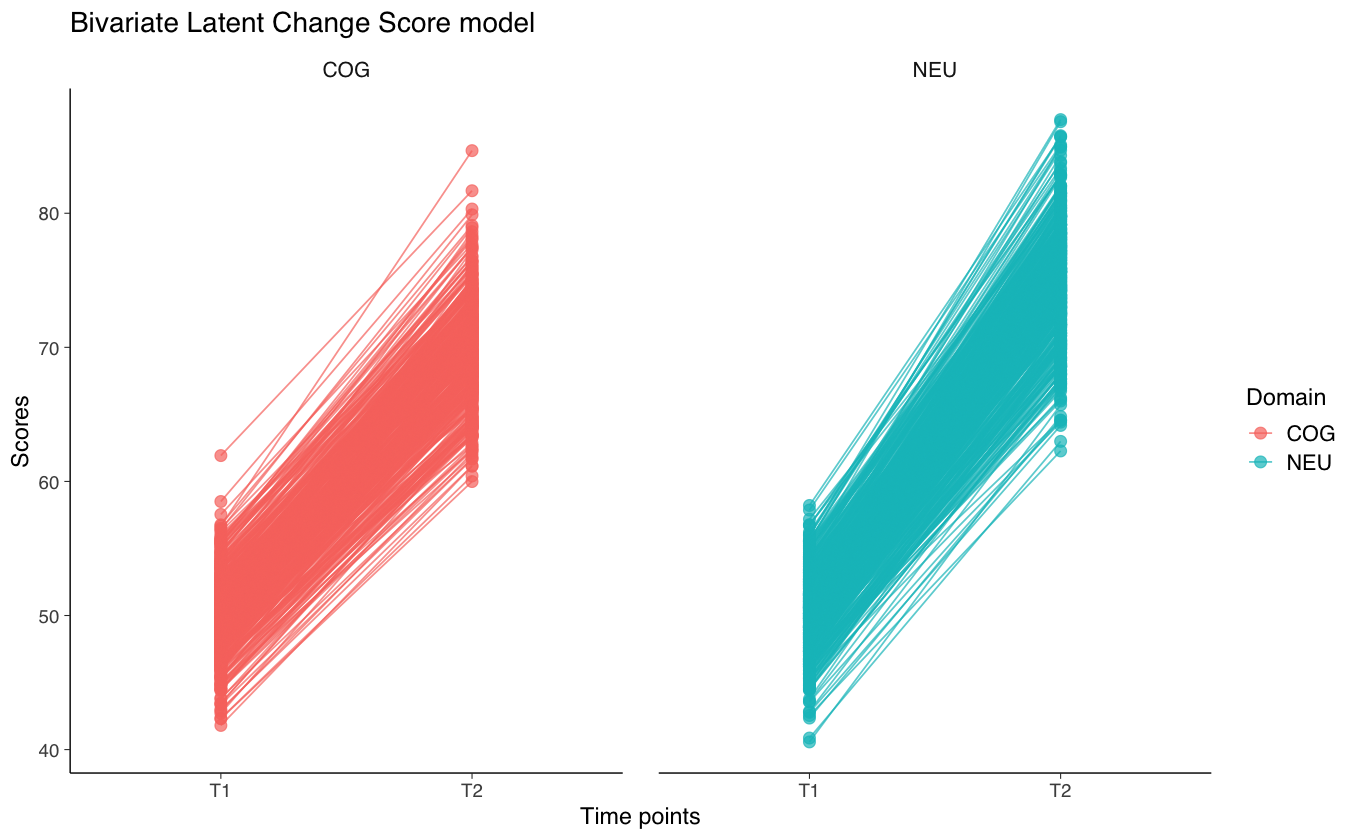

In [29]:
# theme_set(theme_grey(base_size = 18)) # increase text size
id <- factor(1:samplesize)
plotdattemp <- data.frame(c(simdatBLCS$COG_T1, simdatBLCS$NEU_T1), c(simdatBLCS$COG_T2, simdatBLCS$NEU_T2), as.factor(c(id, id)), c(rep("COG", times = samplesize), rep("NEU", times = samplesize)))
colnames(plotdattemp) <- c("T1", "T2", "id", "Domain")
plotdat <- melt(plotdattemp, by = "id")
ggplot(plotdat, aes(variable, value, group = id, col = Domain)) +
    geom_point(size = 3, alpha = .7) +
    geom_line(alpha = .7) +
    ggtitle("Bivariate Latent Change Score model") +
    ylab("Scores") +
    xlab("Time points") +
    facet_grid(~Domain)

Definiamo il modello LCS bivariato.

In [24]:
# Fit the Bivariate Latent Change Score model to simulated data
BLCS <- "
    COG_T2 ~ 1*COG_T1     # This parameter regresses COG_T2 perfectly on COG_T1
    dCOG1 =~ 1*COG_T2     # This defines the latent change score factor as measured perfectly by scores on COG_T2
    dCOG1 ~ 1             # This estimates the intercept of the change score
    COG_T1 ~  1           # This estimates the intercept of COG_T1
    COG_T2 ~ 0*1          # This constrains the intercept of COG_T2 to 0

    NEU_T2 ~ 1*NEU_T1     # This parameter regresses NEU_T2 perfectly on NEU_T1
    dNEU1 =~ 1*NEU_T2     # This defines the latent change score factor as measured perfectly by scores on NEU_T2
    NEU_T2 ~ 0*1          # This line constrains the intercept of NEU_T2 to 0
    NEU_T2 ~~ 0*NEU_T2    # This fixes the variance of the NEU_T1 to 0

    dCOG1 ~~  dCOG1       # This estimates the variance of the change scores
    COG_T1 ~~   COG_T1    # This estimates the variance of the COG_T1
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0

    dNEU1 ~ 1             # This estimates the intercept of the change score
    NEU_T1 ~ 1            # This estimates the intercept of NEU_T1
    dNEU1 ~~ dNEU1        # This estimates the variance of the change scores
    NEU_T1 ~~ NEU_T1      # This estimates the variance of NEU_T1

    dNEU1~COG_T1+NEU_T1   # This estimates the COG to NEU coupling parameter and the COG to COG self-feedback
    dCOG1~NEU_T1+COG_T1   # This estimates the NEU to COG coupling parameter and the NEU to NEU self-feedback

    COG_T1 ~~  NEU_T1     # This estimates the COG_T1 NEU_T1 covariance
    dCOG1~~dNEU1          # This estimates the dCOG and dNEU covariance
"

Adattiamo il modello ai dati simulati.

In [25]:
fitBLCS <- lavaan(BLCS, data = simdatBLCS, estimator = "mlr", fixed.x = FALSE, missing = "fiml")

Esaminiamo la soluzione ottenuta.

In [27]:
summary(fitBLCS, fit.measures = TRUE, standardized = TRUE, rsquare = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 118 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        14

  Number of observations                           500
  Number of missing patterns                         1

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                 0.000       0.000
  Degrees of freedom                                 0           0

Model Test Baseline Model:

  Test statistic                              1516.087    1567.028
  Degrees of freedom                                 6           6
  P-value                                        0.000       0.000
  Scaling correction factor                                  0.967

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000       1.000
  Tucker-Lewis Index (TLI)                      

Possiamo rispondere alle quattro domande di interesse precedentemente menzionate riguardanti le relazioni cervello-comportamento nel modo seguente:

1. **Covarianza Cervello-Comportamento alla Baseline**: Nel modello, la covarianza tra COG_T1 (cognizione) e NEU_T1 (struttura cerebrale) al tempo T1 è stimata a 5.552, con un errore standard di 0.479. Questo valore significativo (P<0.000) indica una relazione forte e significativa tra la cognizione e la struttura cerebrale al momento di baseline.

2. **Accoppiamento Cognizione-Cervello**: Il parametro γ1, che riflette come i punteggi cognitivi a T1 influenzano la struttura cerebrale, è stimato a 0.274 per NEU_T1 influenzando dCOG1, con un errore standard di 0.044 e un P-value di 0.000. Ciò suggerisce una relazione significativa, dove le variazioni iniziali nella cognizione hanno un impatto sul cambiamento successivo nella struttura cerebrale.

3. **Struttura Cerebrale Predittiva del Cambiamento Cognitivo**: Il parametro γ2, che mostra come la struttura cerebrale a T1 influisce sul cambiamento cognitivo, è rappresentato dalla stima di 0.392 per COG_T1 che influisce su dNEU1, con un errore standard di 0.047 e un P-value di 0.000. Questo suggerisce che la struttura cerebrale iniziale ha un impatto significativo sul tasso di cambiamento cognitivo.

4. **Stima del Cambiamento Correlato**: La covarianza tra i cambiamenti in cognizione e struttura cerebrale (dCOG1 e dNEU1) è stimata a 0.618, con un errore standard di 0.210 e un P-value di 0.003. Questo indica che c'è una correlazione significativa tra i cambiamenti nel cervello e nel comportamento che va oltre gli effetti diretti misurati.

In sintesi, il modello BLCS fornisce una comprensione dettagliata delle relazioni dinamiche tra cognizione e struttura cerebrale, mostrando sia le correlazioni di base sia i modi in cui questi due domini influenzano reciprocamente i rispettivi cambiamenti nel tempo. 